# Puzzle

The objective of the puzzle is to identify which customers are able to honor their debt if they receive loans from a credit company.

I divided the notebook into the following sections:
* **Importing**: Importing libraries and I will use during the solution
* **EDA (Exploratory Data Analysis)**: Checking the datasets provided and doing sanity checks to ensure that everything is ok
* **Dataprep**: Data preparation for modelling
    * **Categorical features**: Preparation on categorical features       
    * **Numerical features**: Preparation on numerical features        
* **Modelling**: Modelling of the dataset
* **Results**: Results in the valid dataset (ROC AUC, RECALL, ACCURACY)
* **Conclusion**: Conclusion of the best model
* **Submission**: Exporting csv with predicted defaults
* **Business**:
    * **Use of the model**: How the model could be used for better business decisions
    * **Best model according to business**: Explanation of the best model that maximizes gain of the company

## Importings

In [557]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dython import nominal
import itertools
import seaborn as sns
import missingno as msno
from math import ceil
from dython import nominal
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## EDA (Exploratory Data Analysis)

In [558]:
df_train = pd.read_csv('puzzle_train_dataset.csv')
df_test = pd.read_csv('puzzle_test_dataset.csv')

In [559]:
df_train.shape, df_test.shape

((64592, 27), (35000, 26))

First of all, let's check the proportion of the target.

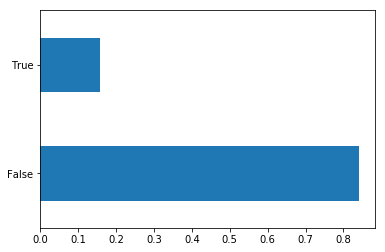

In [3]:
df_train['default'].value_counts(normalize=True).plot.barh()

More than `80%` of the data has `default = 0`.

Below we can see the columns that have missing values.

### Missing values

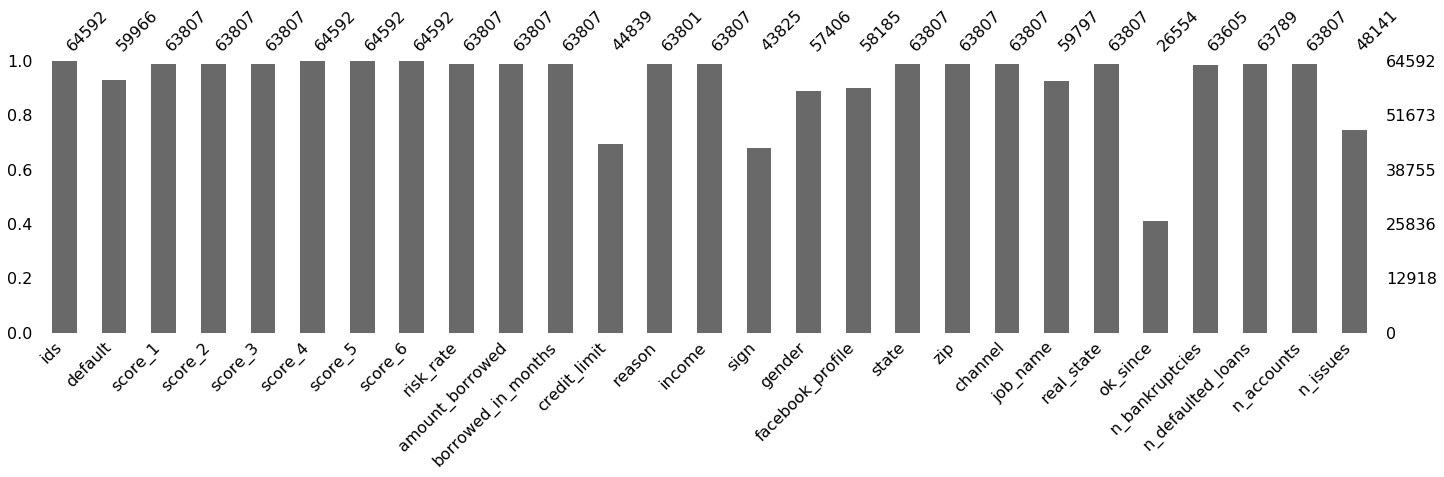

In [3]:
msno.bar(df_train, figsize=(24, 5))

The target `default` contains missing values, so I will drop these rows, since they will not help during the prediction.

In [560]:
df_train.dropna(subset=['default'], inplace=True)
df_train['default'] = df_train['default'].astype('uint8')

By doing this, we can also see that the number of columns that contain missing values decreased.

Next, I will examine deeper the columns that contain categorical and numerical variables.

<========= Bar =========>


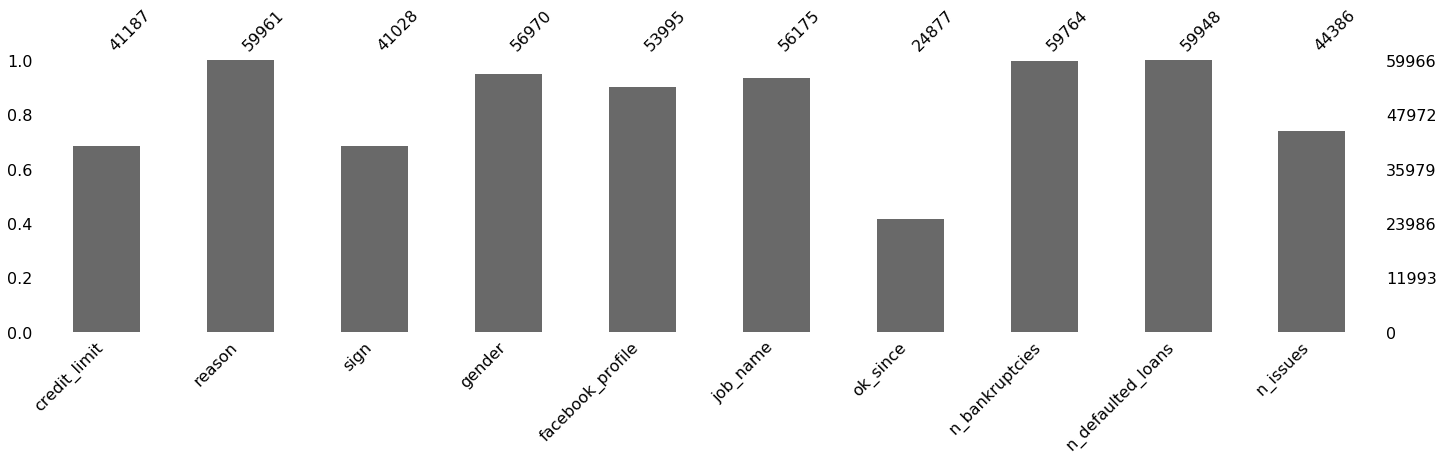

<========= Heatmap =========>


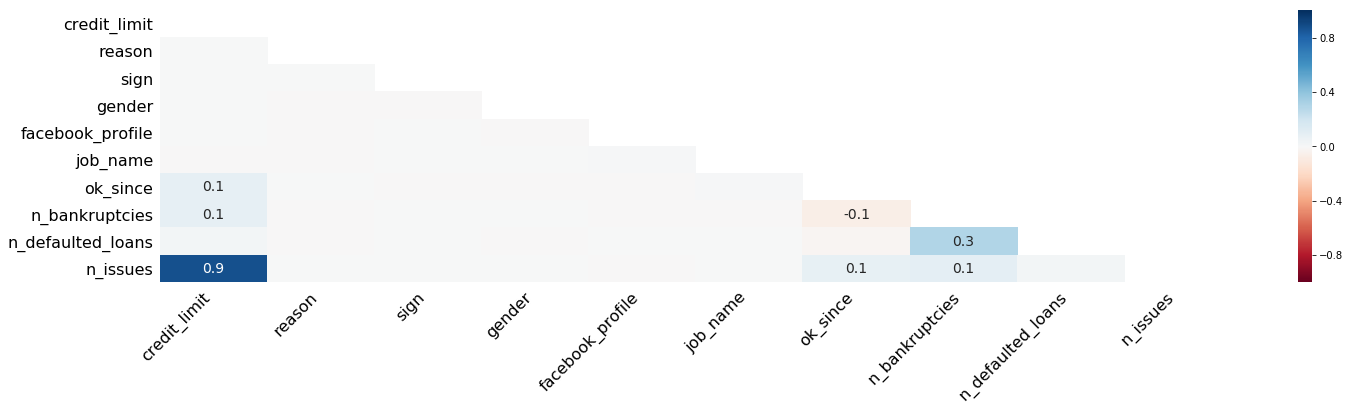

<========= Dendogram =========>


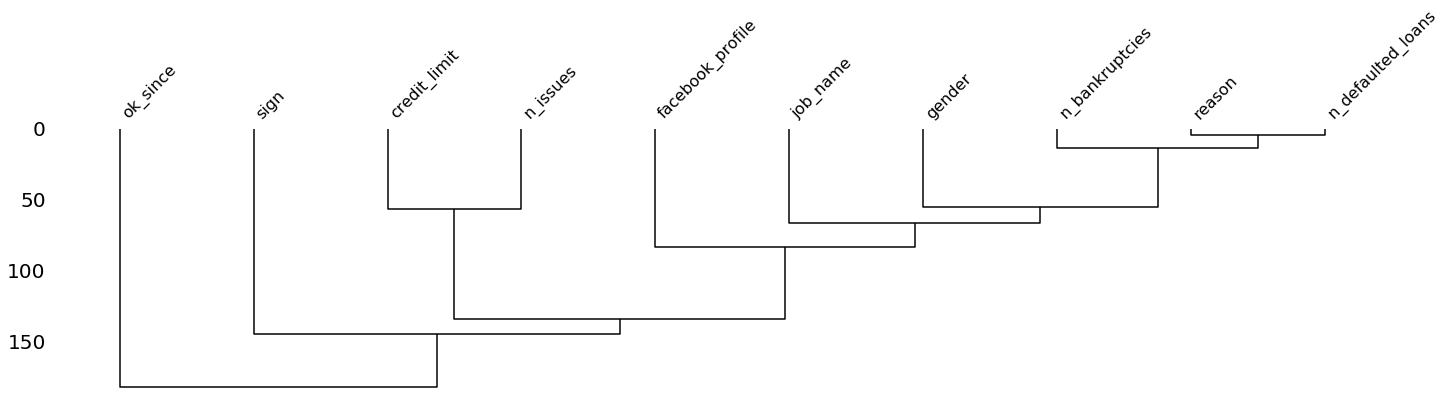

In [103]:
def plot_msno(df, only_null=True):
    if only_null:
        only_missing_cols = df.columns[df.isnull().any()].tolist()
        df = df[only_missing_cols]
    
    print('<========= Bar =========>')
    msno.bar(df, figsize=(24, 5))
    plt.show()        
    
    print('<========= Heatmap =========>')
    msno.heatmap(df, figsize=(24, 5))
    plt.show()
    
    print('<========= Dendogram =========>')
    msno.dendrogram(df, figsize=(24, 5))
    plt.show()
    
plot_msno(df_train)

## Dataprep

I will check the number of unique values `nunique` and the number of missing values `sum of nans`, for each column.

In [376]:
print('<=== Categorical values ===>\n')
for col in df_train.select_dtypes(include='O').columns.tolist():
    print(f'Column: {col:>18} | nunique: {df_train[col].nunique():>7} | sum of nans {df_train[col].isnull().sum():>7}')

print('\n<=== Numerical values ===>\n')    
for col in df_train.select_dtypes(exclude='O').columns.tolist():    
    print(f'Column: {col:>18} | nunique: {df_train[col].nunique():>7} | sum of nans: {df_train[col].isnull().sum():>7}')

<=== Categorical values ===>

Column:                ids | nunique:   59966 | sum of nans       0
Column:            score_1 | nunique:       7 | sum of nans       0
Column:            score_2 | nunique:      35 | sum of nans       0
Column:             reason | nunique:   19496 | sum of nans       5
Column:               sign | nunique:      12 | sum of nans   18938
Column:             gender | nunique:       2 | sum of nans    2996
Column:   facebook_profile | nunique:       2 | sum of nans    5971
Column:              state | nunique:      50 | sum of nans       0
Column:                zip | nunique:     830 | sum of nans       0
Column:            channel | nunique:       1 | sum of nans       0
Column:           job_name | nunique:   42263 | sum of nans    3791
Column:         real_state | nunique:       5 | sum of nans       0

<=== Numerical values ===>

Column:            default | nunique:       2 | sum of nans:       0
Column:            score_3 | nunique:      87 | sum of n

The `channel` column has only one constant value, so I will drop it.

In [561]:
# dropping channel
df_train.drop('channel', axis=1, inplace=True)
df_test.drop('channel', axis=1, inplace=True)

I will plot the distribution of each feature for each value of the target to check if we can have any insights from the data.

<Figure size 432x288 with 0 Axes>

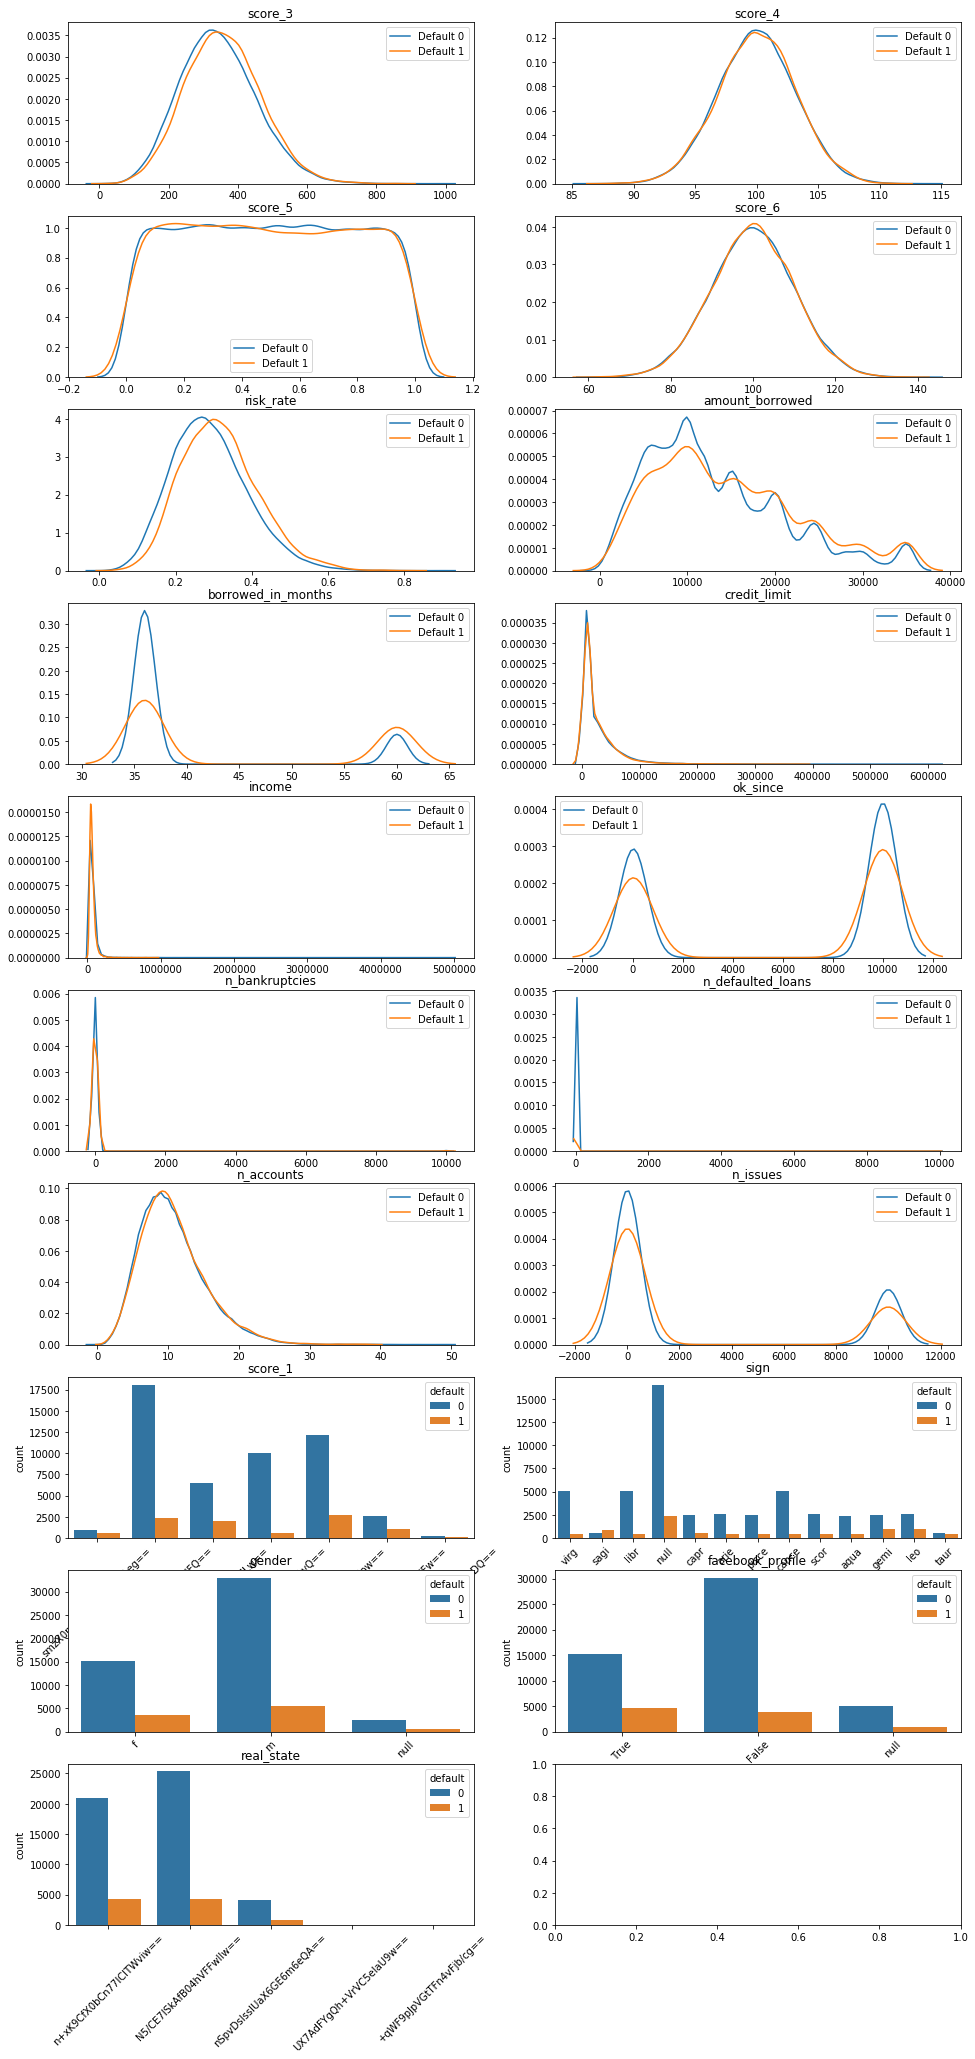

In [562]:
def plot_distributions(df, target='default', nunique_threshold=34,  fillna_cat='null', fillna_num=9999):
    col_nunique_threshold = []
    for col in df.select_dtypes(include='O').columns:
        if df[col].nunique() < nunique_threshold:
            col_nunique_threshold.append(col)
                            
    df = df[df.select_dtypes(exclude='O').columns.tolist() + col_nunique_threshold]
    
    rows_subplots = ceil((df.shape[1] - 1)/2)
    
    cols_num = df.select_dtypes(exclude='O').columns.tolist()
    cols_num.remove(target)
    cols_cat = df.select_dtypes(include='O').columns.tolist()
    
    df[cols_num] = df[cols_num].fillna(fillna_num)
    df[cols_cat] = df[cols_cat].fillna(fillna_cat)
            
    df_default_0 = df[df[target] == 0]
    df_default_1 = df[df[target] == 1]

    plt.figure()
    fig, ax = plt.subplots(rows_subplots, 2, figsize=(16, 35))
    
    i = 0
    for col in cols_num:
        i += 1        
        plt.subplot(rows_subplots, 2, i)
        sns.kdeplot(df_default_0[col], label='Default 0')
        sns.kdeplot(df_default_1[col], label='Default 1')
        plt.title(col)
                
    for col in cols_cat:
        i += 1
        plt.subplot(rows_subplots, 2, i)
        sns.countplot(x=col,hue=target, data=df)
        plt.title(col)
        plt.xlabel(None)
        plt.xticks(rotation=45)            
    plt.show()
    
plot_distributions(df_train)

For the features that still contain missing values, I will add a column called `nan_(name of the feature)`, with has `value = 1` if the feature is missing and `0` otherwise.

The idea here is to check whether the absence of value could discriminate the data.

In [137]:
only_missing_cols = df_train.columns[df_train.isnull().any()].tolist()

In [169]:
def add_missing_col(df, only_missing_cols=only_missing_cols):
    for col in only_missing_cols:
        df['nan_' + col] = np.where(df[col].isnull(), 1, 0)
    return df

In [378]:
df_train = add_missing_col(df_train)
df_test = add_missing_col(df_test)

### Categorical features

For the categorical features, I will check with Cramer's V if there are any features that are correlated with each other.

Running the algorithm with all features was giving me memory error, so I ran 3 times the Cramer's V with the following features:
* 1) all features except `reason`
* 2) all features except `job_name`
* 3) only `reason`, `job_name`

In [125]:
cols_cat = df_train.select_dtypes(include='O').columns.tolist()
cols_cat.remove('ids')
cols_cat.remove('reason')

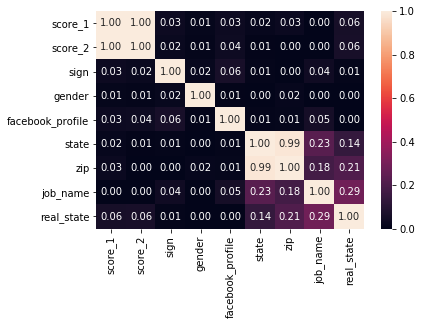

In [12]:
nominal.associations(df_train[cols_cat], nominal_columns='all', nan_strategy=None, nan_replace_value='null')

In [ ]:
cols_cat = df_train.select_dtypes(include='O').columns.tolist()
cols_cat.remove('ids')
cols_cat.remove('job_name')

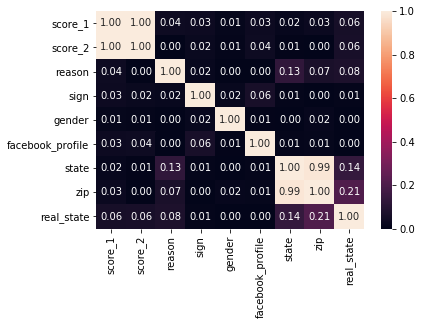

In [15]:
nominal.associations(df_train[cols_cat], nominal_columns='all', nan_strategy=None, nan_replace_value='null')

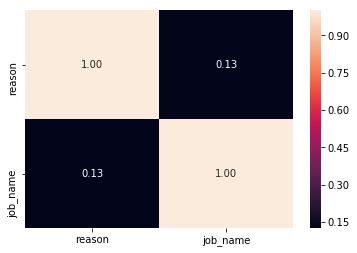

In [17]:
nominal.associations(df_train[['reason','job_name']], nominal_columns='all', nan_strategy=None, nan_replace_value='null')

Apparently, the features `score_1` and `score_2` are redundant, as well as `state` and `zip`.

I will look deeper into them.

##### score_1 and score_2

The function `plot_col` plots two graphs, the first will count the number of rows for each value in a feature, and the second will give the probability of default for each value.

I will use it to identify which values indicate the higher and lower probability of default.

In [33]:
def plot_col(df, col, fillna=None, target='default', figsize=(16, 5)):
    if fillna:
        df = df.fillna(fillna)
    print(f'<========= {col} =========>')
    df.groupby(col)[target].agg(['count', 'mean']).sort_values('mean').plot.bar(subplots=True, figsize=figsize, rot=45)
    plt.show()

<========= score_1 =========>


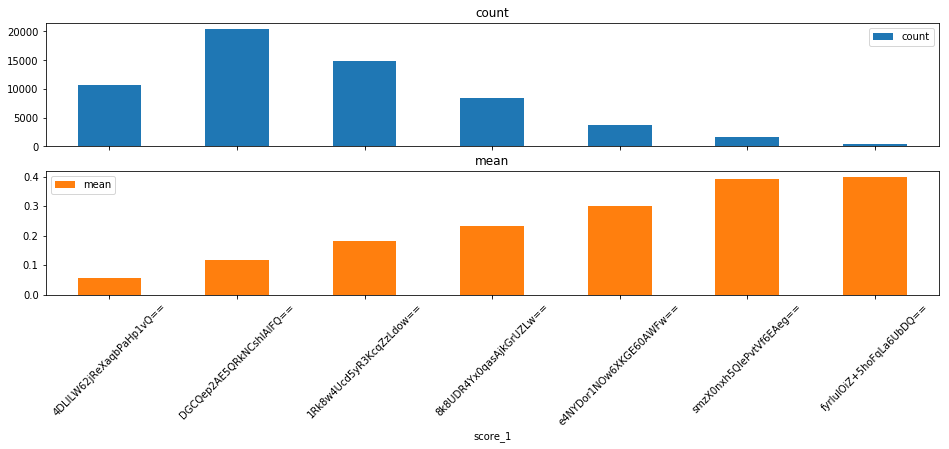

In [38]:
plot_col(df_train, 'score_1')

<========= score_2 =========>


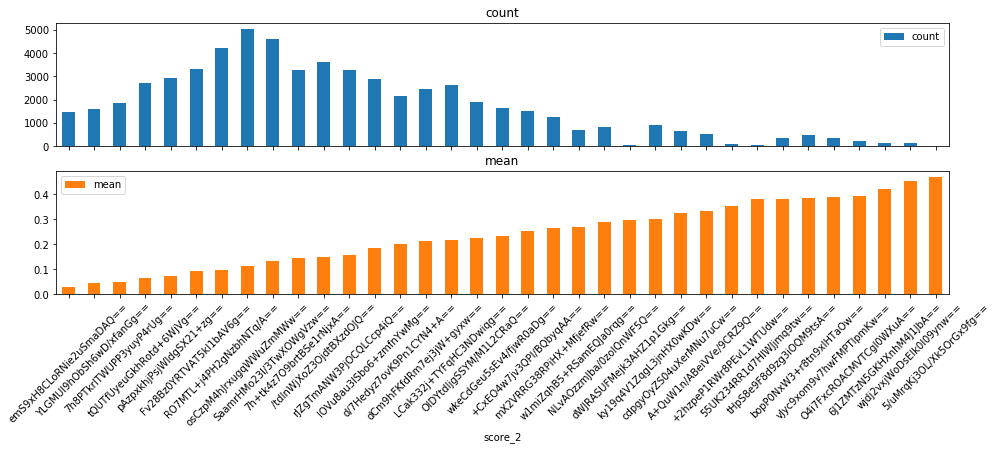

In [39]:
plot_col(df_train, 'score_2')

The values of the `score_1` and `score_2` are encrypted, so I used the function `category_to_numeric` to rename them to integer values. By doing this, I am kind of applying label encoder, but labeling the features by order of probability of default.

In [161]:
def category_to_numeric(df_train, df_test, col, target='default', qcut=None):

    df_group = df_train.groupby(col)[target].agg(mean='mean').sort_values('mean')
    
    if qcut:
        df_group = pd.qcut(df_group['mean'], q=qcut, labels=False)
        dict_num = {key: value for (key, value) in zip(df_group.index, df_group)}   
        
    else:
        dict_num = {key: value for (value, key) in enumerate(df_group.index)}        
        
    df_train[col + '_num'] = df_train[col].map(dict_num)
    df_test[col + '_num'] = df_test[col].map(dict_num)
    
    df_train = df_train.drop(col, axis=1)
    df_test = df_test.drop(col, axis=1)
     
    return df_train, df_test

In [379]:
df_train, df_test = category_to_numeric(df_train, df_test, 'score_1')
df_train, df_test = category_to_numeric(df_train, df_test, 'score_2')

Now we can see that low values of `score_1_num` coincide with low values of `score_2_num`, as well as for higher values.

In [30]:
def plot_heatmap(df, index, column, values='default', figsize=(15, 10)):
    plt.figure(figsize=figsize)
    sns.heatmap(pd.pivot_table(df, index=df[index], columns=df[column],
                           values=values, aggfunc='mean'))
    plt.show()

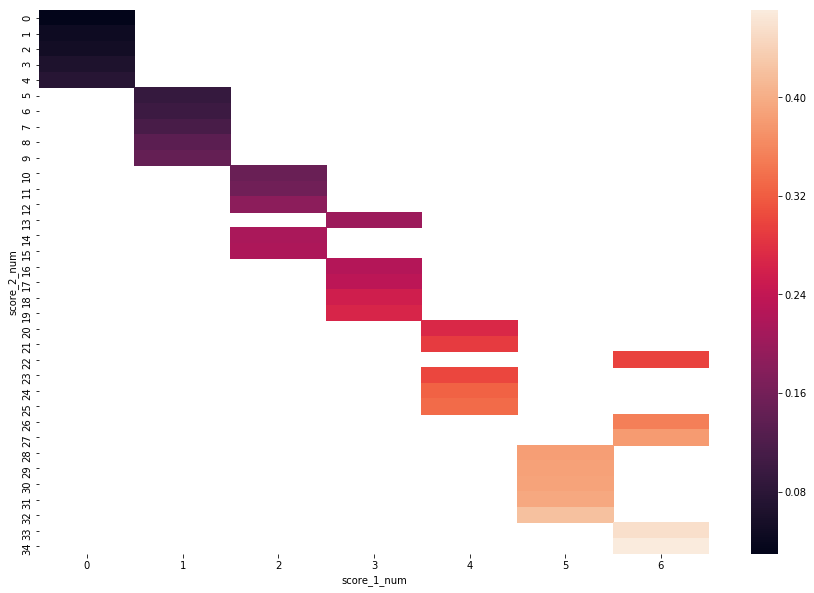

In [172]:
plot_heatmap(df_train, 'score_2_num', 'score_1_num')

Apparently `score_2_num` helps discriminate the dataset better than `score_1_num`, so I will drop the last one.

In [380]:
df_train.drop('score_1_num', axis=1, inplace=True)
df_test.drop('score_1_num', axis=1, inplace=True)

##### state and zip

Doing the same analysis for `state` and `zip`, we can see that most of the values have probability of default of `20%`. 

<========= state =========>


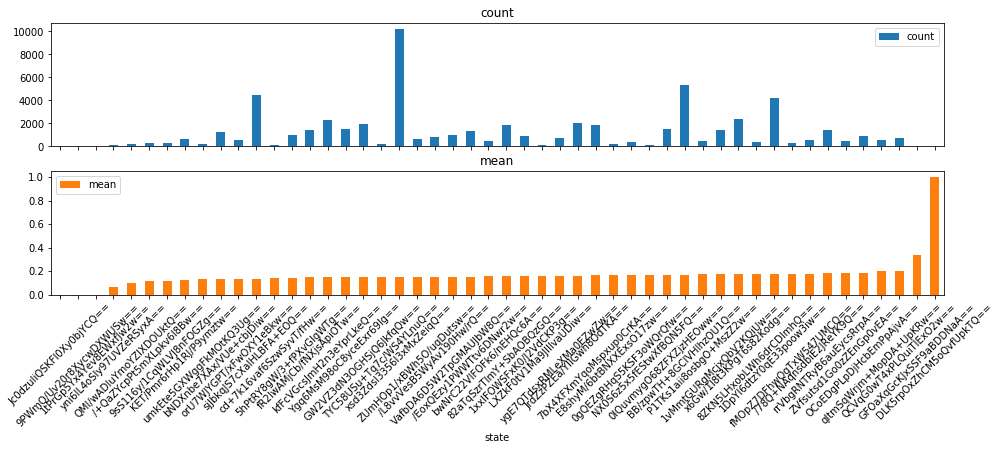

In [343]:
plot_col(df_train, 'state')

<========= zip =========>


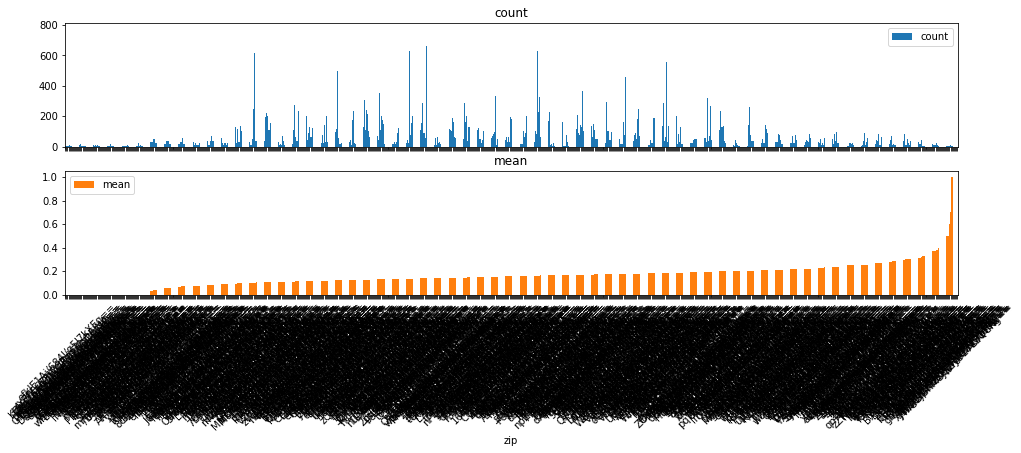

In [344]:
plot_col(df_train, 'zip')

I will use `category_to_numeric` to decrease the number of values, by discretizing them using a quantile based function.

<========= state_num =========>


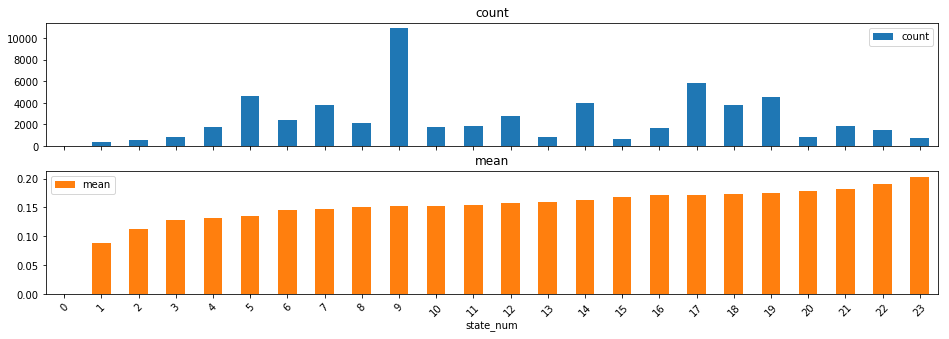

In [381]:
df_train, df_test = category_to_numeric(df_train, df_test, 'state', qcut=24)

plot_col(df_train, 'state_num')

<========= zip_num =========>


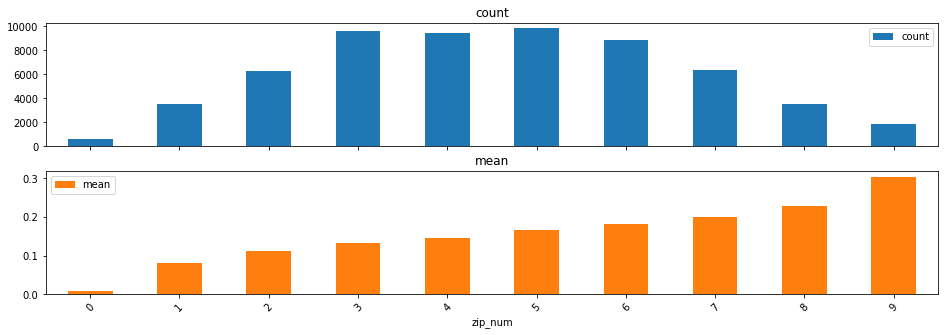

In [382]:
df_train, df_test = category_to_numeric(df_train, df_test, 'zip', qcut=10)

plot_col(df_train, 'zip_num')

I will keep `zip_num` for training and eliminate the `state_num` from the dataset.

In [383]:
df_train.drop('state_num', axis=1, inplace=True)
df_test.drop('state_num', axis=1, inplace=True)

##### real state

By looking at the `real_state`, we can see that the values at the edges are quite insignificant, so I will discretize them to increase the volume of each category.

<========= real_state =========>


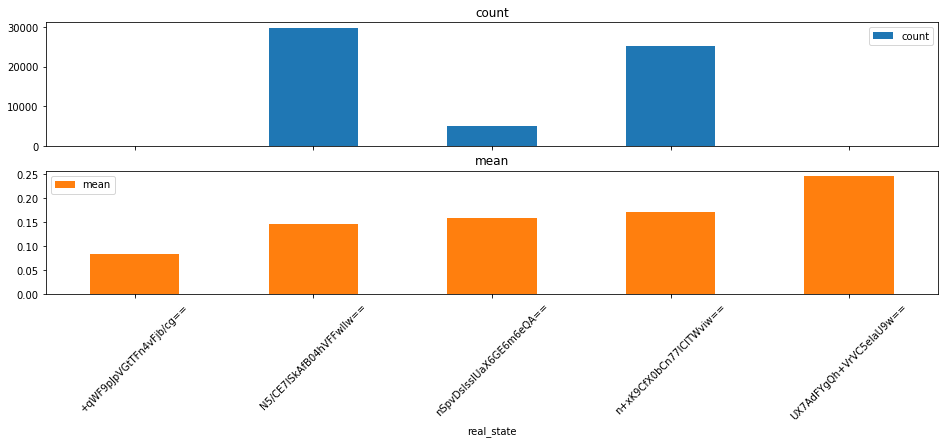

In [373]:
plot_col(df_train, 'real_state')

<========= real_state_num =========>


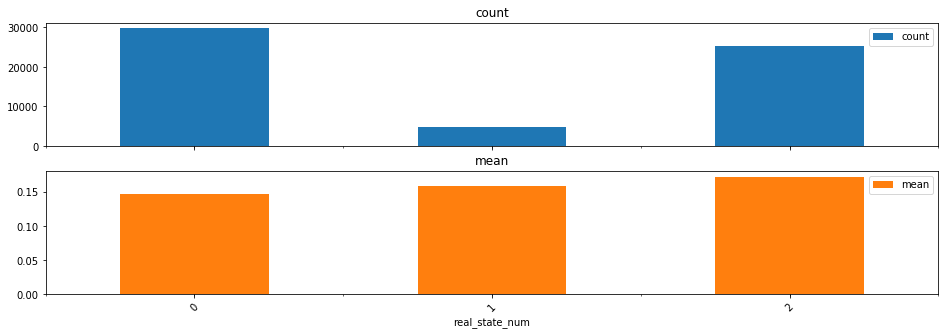

In [384]:
df_train, df_test = category_to_numeric(df_train, df_test, 'real_state', qcut=3)
plot_col(df_train, 'real_state_num')

##### sign

By looking at the data, some signs like `gemi`, `taur` and `sagi` are really discriminating the dataset, but I can't understand the reason. I will try to discretize them by half of the number of signs in the dataset.

<========= sign =========>


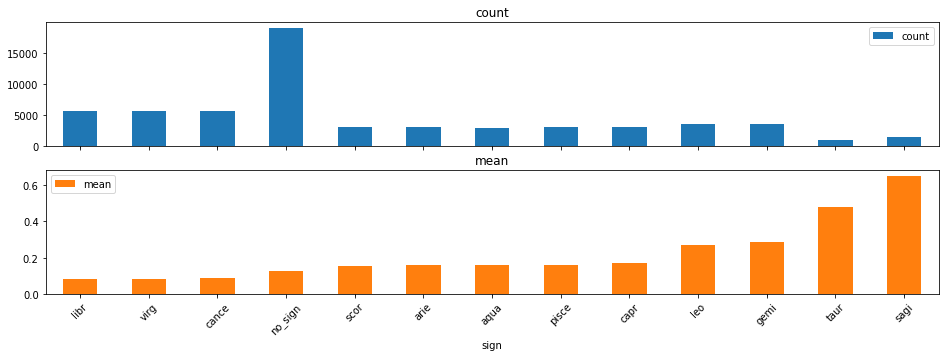

In [38]:
plot_col(df_train, 'sign', fillna='no_sign')

<========= sign_num =========>


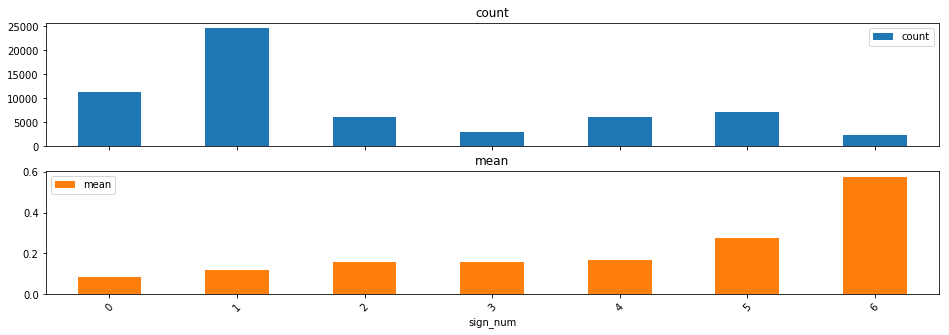

In [385]:
df_train['sign'].fillna('no_sign', inplace=True)
df_test['sign'].fillna('no_sign', inplace=True)

df_train, df_test = category_to_numeric(df_train, df_test, 'sign', qcut=7)

plot_col(df_train, 'sign_num')

##### reason

`80%` of values in `reason` are related to `default = 0`, and `16%` of values are related to `default = 1`.
In this case, I discretize the feature by only three values: 
* `reason_num = 0` for all `reason` that only has `default = 0`
* `reason_num = 2` for all `reason` that only has `default = 1`
* `reason_num = 1` for any other values of `reason`

In [472]:
df_train.groupby('reason')['default'].mean().value_counts(True)

0.000000    0.805704
1.000000    0.130642
0.500000    0.017439
0.333333    0.009130
0.250000    0.005078
              ...   
0.106667    0.000051
0.045455    0.000051
0.193548    0.000051
0.233333    0.000051
0.388889    0.000051
Name: default, Length: 191, dtype: float64

In [182]:
def category_to_numeric_where(df_train, df_test, col, target='default', fillna='null'):
    df_train[col] = df_train[col].fillna(fillna)
    df_test[col] = df_test[col].fillna(fillna)
        
    df_group = df_train.groupby(col)[target].mean().to_frame()
    
    df_group['where'] = np.where(df_group[target]==1, 2, 
                                 np.where(df_group[target]==0, 0, 1))
    
    dict_num = {key: value for (key, value) in zip(df_group.index, df_group['where'])}
    
    df_train[col + '_num'] = df_train[col].map(dict_num)
    df_test[col + '_num'] = df_test[col].map(dict_num)
    
    df_train = df_train.drop(col, axis=1)
    df_test = df_test.drop(col, axis=1)
     
    return df_train, df_test

In [386]:
df_train, df_test = category_to_numeric_where(df_train, df_test, 'reason')

<========= reason_num =========>


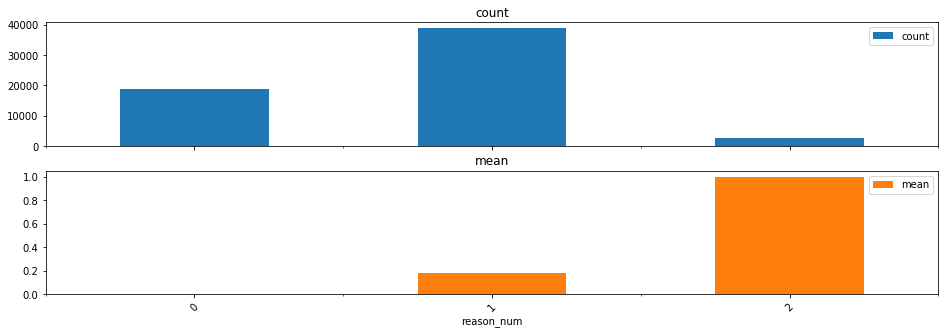

In [197]:
plot_col(df_train, 'reason_num')

##### job name

I did the same treating for `job_name`:

* `job_name_num = 0` for all `job_name` that only has `default = 0`
* `job_name_num = 1` for all `job_name` that only has `default = 1`
* `job_name_num = 2` for any other values of `job_name`

In [512]:
df_train.groupby('job_name')['default'].mean().value_counts(True)

0.000000    0.816648
1.000000    0.147576
0.500000    0.013889
0.333333    0.005915
0.250000    0.002887
              ...   
0.051282    0.000024
0.136364    0.000024
0.131579    0.000024
0.042553    0.000024
0.128440    0.000024
Name: default, Length: 103, dtype: float64

In [387]:
df_train, df_test = category_to_numeric_where(df_train, df_test, 'job_name')

<========= job_name_num =========>


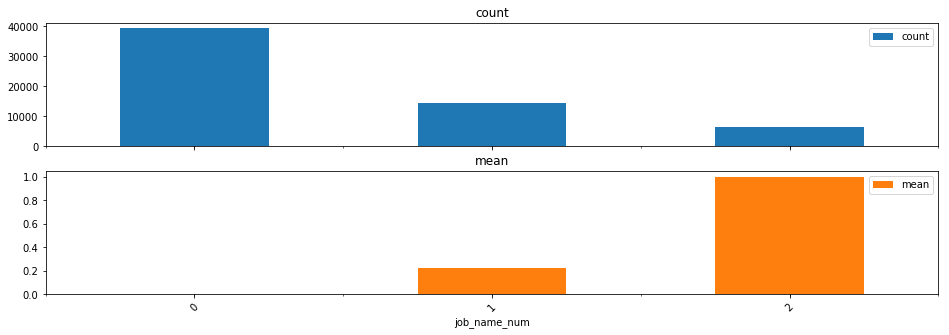

In [199]:
plot_col(df_train, 'job_name_num')

##### gender and facebook_profile

`gender` and `facebook_profile` have both two unique values as presented in the table of `nunique` values. I will apply one hot encoding (`get_dummies` in pandas), to obtain a new column with each value of each feature.

When both values of the same feature is 0, the value is missing.

In [389]:
df_train = pd.get_dummies(df_train, columns=['gender', 'facebook_profile'])
df_test = pd.get_dummies(df_test, columns=['gender', 'facebook_profile'])

### Numerical features

In [75]:
cols_num = ['default', 'score_3', 'score_4', 'score_5', 'score_6', 'risk_rate',
            'amount_borrowed', 'borrowed_in_months', 'credit_limit', 'income',
            'ok_since', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues']

Now, I will use pearson correlation to check whether there are any numeric features that are correlated.

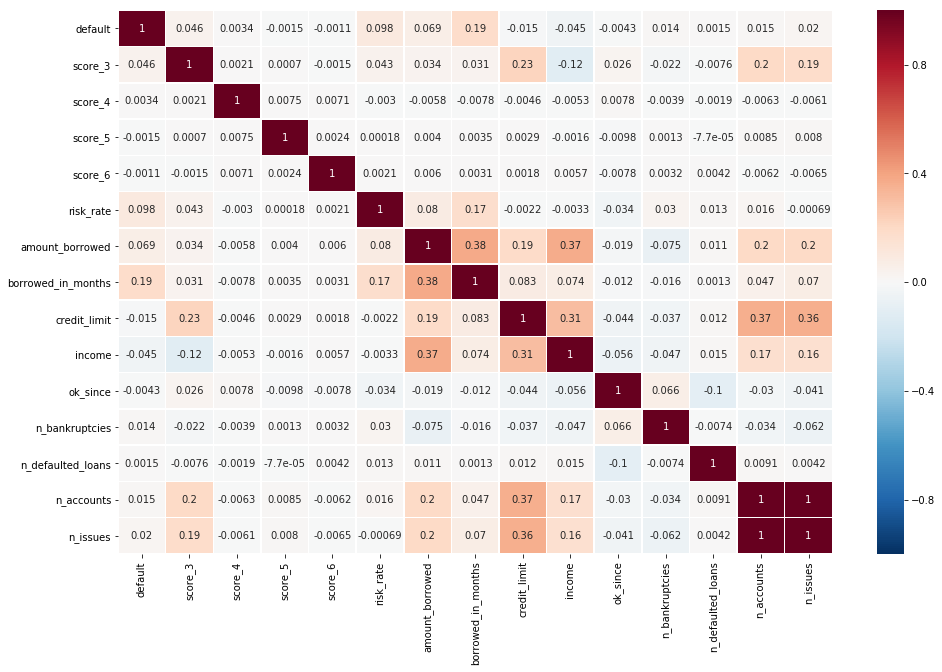

In [76]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_train[cols_num].corr(), vmin=-1, cmap='RdBu_r', annot=True, linewidths=.5)

`n_accounts` and `n_issues` are very correlated. 

Since `n_issues` contains `15580` missing values, I will drop it from the dataset.

##### n_accounts and n_issues

Below we can check the distribution of `n_accounts` and `n_issues`, colored by each value of `default`.
Missing values are replaced by `-900`.

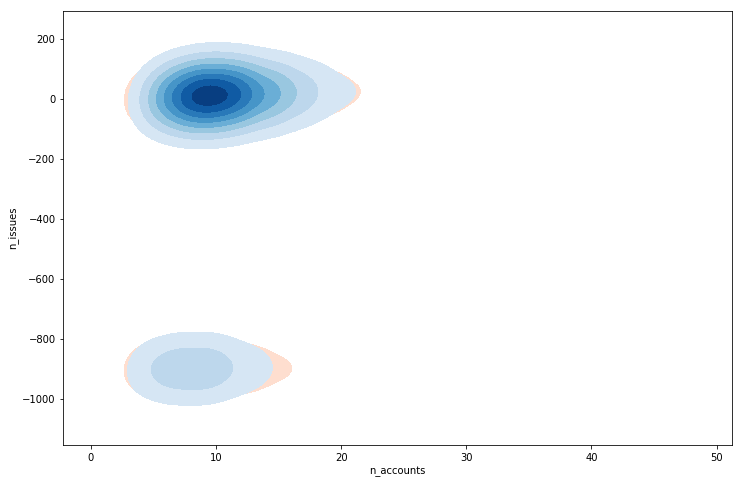

In [78]:
df_n_accounts_issues = df_train[['n_accounts', 'n_issues', 'default']].copy()

df_n_accounts_issues.fillna(-900, inplace=True)

df_0 = df_n_accounts_issues.query('default == 0')
df_1 = df_n_accounts_issues.query('default == 1')

plt.figure(figsize=(12, 8))

ax = sns.kdeplot(df_0['n_accounts'], df_0['n_issues'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(df_1['n_accounts'], df_1['n_issues'],
                 cmap="Blues", shade=True, shade_lowest=False)

In [390]:
df_train.drop('n_issues', axis=1, inplace=True)
df_test.drop('n_issues', axis=1, inplace=True)

##### credit_limit

We can see the distribution of `credit_limit` for each value of default. 
I replaced missing values by `-99999`.

In [82]:
def plot_hist(df, col, target='default', bins=50, fillna=None, figsize=(16, 4)):
    df_plot = df.copy()
    df_plot[col] = df_plot[col].fillna(fillna)
    
    df_0 = df_plot.query('default == 0')
    df_1 = df_plot.query('default == 1')
    
    plt.figure(figsize=figsize)

    plt.hist(df_0[col], bins=bins, alpha=0.3, label='default = 0', color='b')
    plt.hist(df_1[col], bins=bins, alpha=0.3, label='default = 1', color='r')
    plt.legend(loc='upper right')
    
    plt.show()

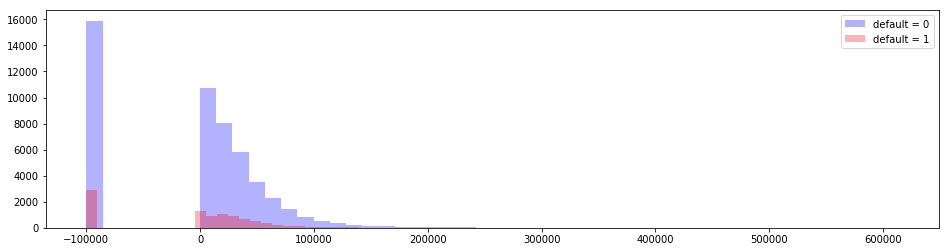

In [666]:
plot_hist(df_train, 'credit_limit', fillna=-99999)

In [391]:
df_train['credit_limit'].fillna(-99999, inplace=True)
df_test['credit_limit'].fillna(-99999, inplace=True)

##### ok_since

We can see the distribution of `ok_since` for each value of default. I replaced missing values by `-1`.

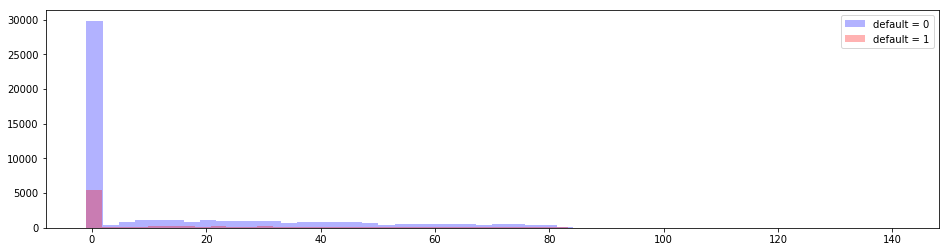

In [203]:
plot_hist(df_train, 'ok_since', fillna=-1)

In [392]:
df_train['ok_since'].fillna(-1, inplace=True)
df_test['ok_since'].fillna(-1, inplace=True)

##### n_bankruptcies 

We can see the distribution of `n_bankruptcies` for each value of default. I replaced missing values by `-1`.

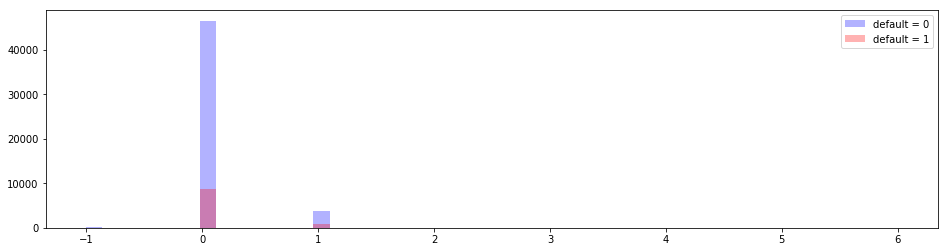

In [83]:
plot_hist(df_train, 'n_bankruptcies', fillna=-1)

In [393]:
df_train['n_bankruptcies'].fillna(-1, inplace=True)
df_test['n_bankruptcies'].fillna(-1, inplace=True)

##### n_defaulted_loans

We can see the distribution of `n_defaulted_loans` for each value of default. I replaced missing values by `-1`.

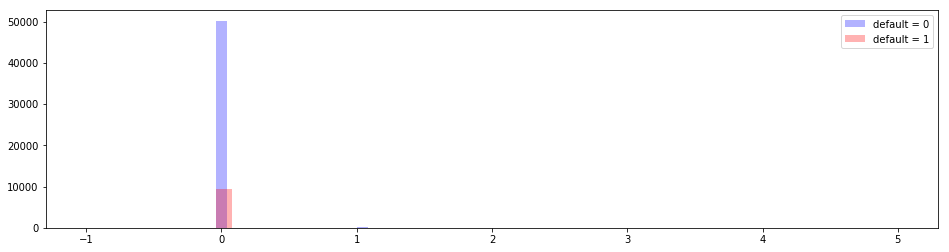

In [677]:
plot_hist(df_train, 'n_defaulted_loans', fillna=-1)

In [394]:
df_train['n_defaulted_loans'].fillna(-1, inplace=True)
df_test['n_defaulted_loans'].fillna(-1, inplace=True)

Now, the dataset is ready for modelling.

## Modelling

When I deleted all the rows of df_train that `default` was missing, I also removed all the missing values of other features like `score_1`, and `score_2`. However, in the test_set there are still missing values in those features that I didn't consider in the `dataprep`. 

So I will use replace the missing value in the test set with `-1`.

In [543]:
df_test.fillna(-1, inplace=True)

I used `MinMaxScaler` to scale all the features equally.

I tried several simple classifiers: `Logistic Regression`, `Decision Tree`, `Random Forest`, `AdaBoost`, `GaussianNB`, and `SVM` to predict the `default`.

I also applied the classifiers with some samplers (`Random_under_sampler` and `Random_over_sampler`) to balance the target, and tested the models without any sampler.

In this method, I obtained `18` pipelines of models.

In [489]:
classifiers = {'Logistic Regression' : LogisticRegression(),
               'Decision Tree': DecisionTreeClassifier(),
               'Random Forest': RandomForestClassifier(),
               'AdaBoost': AdaBoostClassifier(),
               'GaussianNB': GaussianNB()}

samplers = {'Random_under_sampler': RandomUnderSampler(),
            'Random_over_sampler': RandomOverSampler()}

In [326]:
def df_split(df, target='default', drop='ids'):    
    x = df.drop([drop, target], axis=1)
    y = df[target]    
    
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)                          
    return x_train, x_val, y_train, y_val

In [327]:
def train_clfs(df, classifiers=classifiers, samplers=samplers):    
    
    names_samplers = []
    names_clfs = []
    results_val_roc_auc = []
    results_val_recall = []
    results_val_accuracy = []
        
    for name_sampler, sampler in samplers.items():
        print(f'Sampler: {name_sampler}\n')
        for name_clf, clf in classifiers.items():
            print(f'Classifier: {name_clf}\n')
                                                
            pipeline = Pipeline([('minmax', MinMaxScaler()),
                                 ('sampler', sampler),
                                 ('clf', clf)])
            
            val_roc_auc, val_recall, val_accuracy = train_pipeline(pipeline, df)
            
            names_samplers.append(name_sampler)
            names_clfs.append(name_clf)
            results_val_roc_auc.append(val_roc_auc)
            results_val_recall.append(val_recall)
            results_val_accuracy.append(val_accuracy)
    
        
    print(f'Sampler: No Sampler\n')
    
    for name_clf, clf in classifiers.items():
        print(f'Classifier: {name_clf}\n')

        pipeline = Pipeline([('minmax', MinMaxScaler()),
                             ('clf', clf)])

        val_roc_auc, val_recall, val_accuracy = train_pipeline(pipeline, df)

        names_samplers.append('No_Sampler')
        names_clfs.append(name_clf)
        results_val_roc_auc.append(val_roc_auc)
        results_val_recall.append(val_recall)
        results_val_accuracy.append(val_accuracy)  

    df_results_val = pd.DataFrame(index=[names_clfs, names_samplers], columns=['ROC_AUC', 'RECALL', 'ACCURACY'])
    df_results_val['ROC_AUC'] = results_val_roc_auc
    df_results_val['RECALL'] = results_val_recall
    df_results_val['ACCURACY'] = results_val_accuracy

    return df_results_val

In [328]:
def train_pipeline(pipeline, df):
    
    x_train, x_val, y_train, y_val = df_split(df)

    pipeline.fit(x_train, y_train)        
    y_pred = pipeline.predict(x_val)    
    
    cv_auc = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='roc_auc') 
    cv_rec = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='recall')                                
    cv_acc = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy') 
    
    val_auc = roc_auc_score(y_val, y_pred)
    val_rec = recall_score(y_val, y_pred)
    val_acc = accuracy_score(y_val, y_pred)

    print(f'CV\troc_auc:\t{round(cv_auc.mean(), 3)}')
    print(f'CV\trecall:\t\t{round(cv_rec.mean(), 3)}')
    print(f'CV\taccuracy:\t{round(cv_acc.mean(), 3)}')

    print(f'\nValid\troc_auc:\t{round(val_auc, 3)}')         
    print(f'Valid\trecall:\t\t{round(val_rec, 3)}')          
    print(f'Valid\taccuracy:\t{round(val_acc, 3)}')      
    print('\n<-------------------------->\n')
    
    return val_auc, val_rec, val_acc

In [330]:
df_results_val = train_clfs(df_train, classifiers, samplers)

Sampler: Random_under_sampler

Classifier: Logistic Regression

CV	roc_auc:	0.992
CV	recall:		0.959
CV	accuracy:	0.934

Valid	roc_auc:	0.948
Valid	recall:		0.964
Valid	accuracy:	0.937

<-------------------------->

Classifier: Decision Tree

CV	roc_auc:	0.924
CV	recall:		0.925
CV	accuracy:	0.925

Valid	roc_auc:	0.925
Valid	recall:		0.925
Valid	accuracy:	0.925

<-------------------------->

Classifier: Random Forest

CV	roc_auc:	0.99
CV	recall:		0.972
CV	accuracy:	0.925

Valid	roc_auc:	0.945
Valid	recall:		0.973
Valid	accuracy:	0.926

<-------------------------->

Classifier: AdaBoost

CV	roc_auc:	0.991
CV	recall:		0.955
CV	accuracy:	0.934

Valid	roc_auc:	0.94
Valid	recall:		0.948
Valid	accuracy:	0.934

<-------------------------->

Classifier: GaussianNB

CV	roc_auc:	0.981
CV	recall:		0.985
CV	accuracy:	0.691

Valid	roc_auc:	0.93
Valid	recall:		0.976
Valid	accuracy:	0.899

<-------------------------->

Classifier: SVM

CV	roc_auc:	0.99
CV	recall:		0.969
CV	accuracy:	0.924

Valid	roc_au

Besides using simple classifiers, I also tried to train using a XGBoost with random search hyperparameter optimization to check if I could get better results.

In this case, I didn't use any samplers because the parameter `scale_pos_weight` already considers the imbalance of dataset.

In [338]:
def train_xgb(df, clf=XGBClassifier()):
    
    scale_pos_weight = len(df.query('default == 0')) / len(df.query('default == 1'))
    
    param_grid = {'xgb__max_depth': [3, 4, 5, 6, 7, 8],
                  'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
                  'xgb__colsample_bytree': [0.6, 0.7, 0.8],
                  'xgb__min_child_weight': [0.4, 0.5, 0.6],
                  'xgb__gamma': [0, 0.01, 0.1],
                  'xgb__reg_lambda': [6, 7, 8, 9, 10],
                  'xgb__n_estimators': [150, 200, 300],
                  'xgb__scale_pos_weight': [scale_pos_weight]}
    
    x_train, x_val, y_train, y_val = df_split(df) 
    
    pipeline = Pipeline([('minmax', MinMaxScaler()), ('xgb', clf)])
    
    rs_clf = RandomizedSearchCV(pipeline, param_grid, n_iter=100,
                                n_jobs=-1, verbose=2, cv=5,                            
                                scoring='roc_auc', random_state=42)
    
    rs_clf.fit(x_train, y_train)
    print(f'XGBOOST BEST PARAMS: {rs_clf.best_params_}')
    
    y_pred = rs_clf.predict(x_val)

    df_results_xgb = pd.DataFrame(index=[['XGBoost'], ['No_sampler']], columns=['ROC_AUC', 'RECALL', 'ACCURACY'])

    df_results_xgb['ROC_AUC'] = roc_auc_score(y_val, y_pred)
    df_results_xgb['RECALL'] = recall_score(y_val, y_pred)
    df_results_xgb['ACCURACY'] = accuracy_score(y_val, y_pred)
    
    return df_results_xgb

In [339]:
df_results_xgb = train_xgb(df_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 46.7min finished


XGBOOST BEST PARAMS: {'xgb__scale_pos_weight': 5.305573080967402, 'xgb__reg_lambda': 6, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 0.6, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.6}


In [341]:
df_results = pd.concat([df_results_val, df_results_xgb])

## Results

We can check the top 3 pipelines for `ROC_AUC`, `RECALL`, and `ACCURACY` in the valid dataset below:

In [351]:
df_plot = pd.concat([df_results.sort_values('ROC_AUC').tail(3),
                     df_results.sort_values('RECALL').tail(3),
                     df_results.sort_values('ACCURACY').tail(3)])

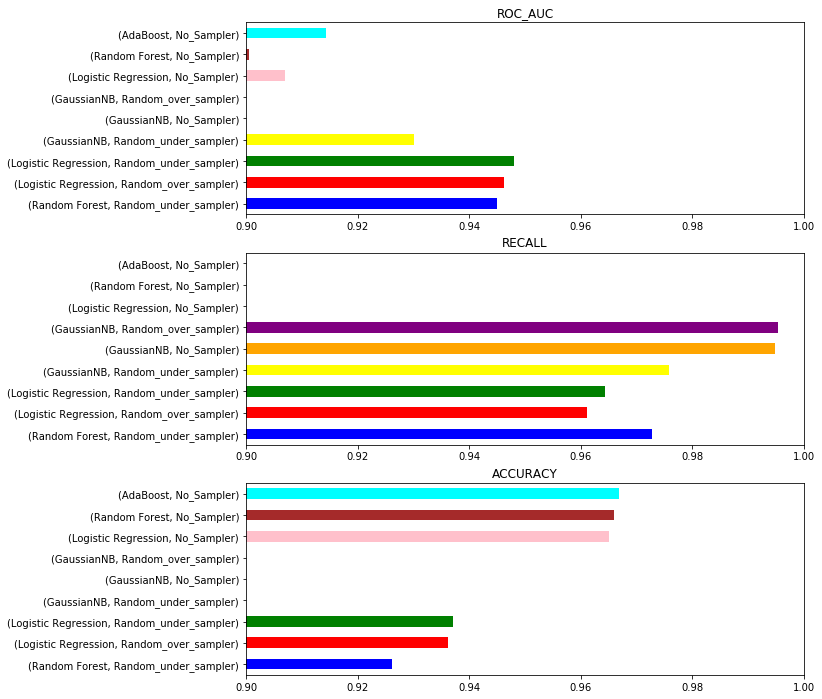

In [358]:
def plot_valid(df, xlim_min, xlim_max):

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))

    color = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'cyan']

    df['ROC_AUC'].plot(kind='barh', ax=ax1, xlim=(xlim_min, xlim_max), title='ROC_AUC', color=color)
    df['RECALL'].plot(kind='barh', ax=ax2, xlim=(xlim_min, xlim_max), title='RECALL', color=color)
    df['ACCURACY'].plot(kind='barh', ax=ax3, xlim=(xlim_min, xlim_max), title='ACCURACY', color=color)
    plt.show()
    

plot_valid(df_plot, 0.90, 1)

The models resulted in quite good metrics for the valid dataset. I will use the pipeline `Logistic Regression + Random Under Sampler` and `Random Forest + Random Under Sampler` to identify which features were the most important for the predictions.

Feature importance was measured using `Permutation Importance`.

In [535]:
def explainer(df, model, scaler=None):        
    x_train, x_val, y_train, y_val = df_split(df)
    
    if scaler:
        pipeline = Pipeline([('minmax', MinMaxScaler()),
                             ('scaler', MinMaxScaler()),
                             ('clf', model)])    
    else:
        pipeline = Pipeline([('minmax', MinMaxScaler()), ('clf', model)])
    
    pipeline.fit(x_train, y_train)            
    y_pred = pipeline.predict(x_val)      
    
    perm = PermutationImportance(pipeline, random_state=42)
    perm = perm.fit(x_val, y_val)
    
    print(f'Valid\troc_auc:\t{round(roc_auc_score(y_val, y_pred), 3)}')         
    print(f'Valid\trecall:\t\t{round(recall_score(y_val, y_pred), 3)}')          
    print(f'Valid\taccuracy:\t{round(accuracy_score(y_val, y_pred), 3)}') 
    
    return pipeline, perm, x_val.columns.tolist()

In [481]:
pipeline, explainer, fnames = explainer(df_train, LogisticRegression(), RandomUnderSampler())

Valid	roc_auc:	0.907
Valid	recall:		0.822
Valid	accuracy:	0.965


In [482]:
show_weights(explainer, feature_names = fnames)

Weight,Feature
0.1632 ± 0.0013,job_name_num
0.0255 ± 0.0030,reason_num
0.0057 ± 0.0019,sign_num
0.0006 ± 0.0009,borrowed_in_months
0.0002 ± 0.0009,zip_num
0.0002 ± 0.0009,facebook_profile_False
0.0001 ± 0.0003,nan_n_issues
0.0001 ± 0.0003,nan_n_bankruptcies
0.0001 ± 0.0003,facebook_profile_True
0 ± 0.0000,n_defaulted_loans


In [486]:
pipeline, explainer, fnames = explainer(df_train, RandomForestClassifier(), RandomUnderSampler())
show_weights(explainer, feature_names = fnames)

Valid	roc_auc:	0.9
Valid	recall:		0.805
Valid	accuracy:	0.966


Weight,Feature
0.1556 ± 0.0022,job_name_num
0.0485 ± 0.0018,reason_num
0.0052 ± 0.0007,sign_num
0.0011 ± 0.0005,borrowed_in_months
0.0009 ± 0.0006,facebook_profile_True
0.0009 ± 0.0007,score_2_num
0.0005 ± 0.0009,facebook_profile_False
0.0003 ± 0.0005,nan_job_name
0.0002 ± 0.0007,score_5
0.0002 ± 0.0007,income


It seems that the two features that I created, `job_name_num` and `reason_num`, are discriminating well the data. However, it may be causing overfitting in the dataset, and can not generalize well on test set.

I will run it again without these two features to check how worst the metrics can get.

In [519]:
df_train_2 = df_train.drop(['job_name_num', 'reason_num'], axis=1)

df_results_val_2 = train_clfs(df_train_2 , classifiers, samplers)

Sampler: Random_under_sampler

Classifier: Logistic Regression

CV	roc_auc:	0.772
CV	recall:		0.685
CV	accuracy:	0.713

Valid	roc_auc:	0.705
Valid	recall:		0.687
Valid	accuracy:	0.716

<-------------------------->

Classifier: Decision Tree

CV	roc_auc:	0.609
CV	recall:		0.601
CV	accuracy:	0.61

Valid	roc_auc:	0.605
Valid	recall:		0.597
Valid	accuracy:	0.61

<-------------------------->

Classifier: Random Forest

CV	roc_auc:	0.767
CV	recall:		0.679
CV	accuracy:	0.717

Valid	roc_auc:	0.695
Valid	recall:		0.656
Valid	accuracy:	0.723

<-------------------------->

Classifier: AdaBoost

CV	roc_auc:	0.776
CV	recall:		0.692
CV	accuracy:	0.715

Valid	roc_auc:	0.701
Valid	recall:		0.67
Valid	accuracy:	0.722

<-------------------------->

Classifier: GaussianNB

CV	roc_auc:	0.746
CV	recall:		0.996
CV	accuracy:	0.267

Valid	roc_auc:	0.673
Valid	recall:		0.774
Valid	accuracy:	0.605

<-------------------------->

Sampler: Random_over_sampler

Classifier: Logistic Regression

CV	roc_auc:	0.774
CV	

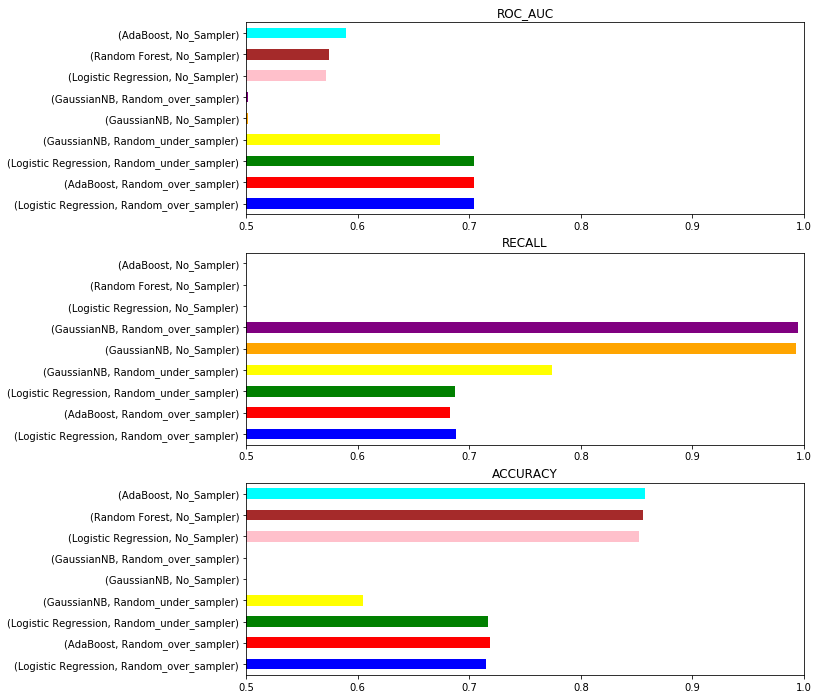

In [521]:
df_plot = pd.concat([df_results_val_2.sort_values('ROC_AUC').tail(3),
                     df_results_val_2.sort_values('RECALL').tail(3),
                     df_results_val_2.sort_values('ACCURACY').tail(3)])

plot_valid(df_plot, 0.5, 1)

In [526]:
pipeline, explainer, fnames = explainer(df_train_2, LogisticRegression(), RandomUnderSampler())

Valid	roc_auc:	0.572
Valid	recall:		0.161
Valid	accuracy:	0.852


In [527]:
show_weights(explainer, feature_names = fnames)

Weight,Feature
0.0169 ± 0.0023,sign_num
0.0064 ± 0.0026,score_2_num
0.0048 ± 0.0012,facebook_profile_False
0.0027 ± 0.0010,zip_num
0.0020 ± 0.0016,borrowed_in_months
0.0018 ± 0.0016,gender_f
0.0016 ± 0.0010,gender_m
0.0014 ± 0.0004,nan_n_issues
0.0009 ± 0.0006,score_3
0.0008 ± 0.0004,nan_credit_limit


In [529]:
pipeline, explainer, fnames = explainer(df_train_2, AdaBoostClassifier(), RandomOverSampler())

Valid	roc_auc:	0.589
Valid	recall:		0.197
Valid	accuracy:	0.857


In [530]:
show_weights(explainer, feature_names = fnames)

Weight,Feature
0.0295 ± 0.0029,sign_num
0.0056 ± 0.0018,score_2_num
0.0048 ± 0.0009,facebook_profile_True
0.0035 ± 0.0010,borrowed_in_months
0.0027 ± 0.0007,zip_num
0.0022 ± 0.0023,income
0.0012 ± 0.0010,nan_facebook_profile
0.0012 ± 0.0008,gender_m
0.0009 ± 0.0015,nan_sign
0.0009 ± 0.0004,amount_borrowed


Now, our roc auc is about 0.57, which is almost guessing the default of customers.
For my submission, I will consider the first approach with all the features, even though it may overfit the data.

## Conclusion

I will plot the confusion matrix for both pipelines `Logistic Regression + Random Under Sampler` and `Random Forest + Random Under Sampler` varying the threshold of the `predict_proba` to identify which threshold gives the highest roc auc.

In [499]:
def plot_confusion_matrix(y_test, y_pred, title='Confusion matrix'):
    
    cm = confusion_matrix(y_test, y_pred)
    classes = ['Default = 0', 'Default = 1']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, )
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def train_clf_threshold(df, clf, sampler=None):
    thresholds = np.arange(0.1, 1, 0.1)
    
    x_train, x_val, y_train, y_val = df_split(df)
    
    if sampler:
        pipeline = Pipeline([('minmax', MinMaxScaler()),
                             ('scaler', sampler),
                             ('clf', clf)])    
    else:
        pipeline = Pipeline([('minmax', MinMaxScaler()), ('clf', clf)])
        
    
    pipeline.fit(x_train, y_train)
    y_proba = pipeline.predict_proba(x_val)
    
    plt.figure(figsize=(10,10))

    j = 1
    for i in thresholds:
        y_pred = y_proba[:,1] > i

        plt.subplot(4, 3, j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_val,y_pred)
        np.set_printoptions(precision=2)

        print(f"Threshold: {round(i, 1)} | Test Recall: {round(recall_score(y_val, y_pred), 2)} | Test Roc Auc: {round(roc_auc_score(y_val, y_pred), 2)}")

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(y_val, y_pred, title=f'Threshold >= {round(i, 1)}')

Threshold: 0.1 | Test Recall: 1.0 | Test Roc Auc: 0.93
Threshold: 0.2 | Test Recall: 1.0 | Test Roc Auc: 0.93
Threshold: 0.3 | Test Recall: 0.99 | Test Roc Auc: 0.94
Threshold: 0.4 | Test Recall: 0.98 | Test Roc Auc: 0.94
Threshold: 0.5 | Test Recall: 0.96 | Test Roc Auc: 0.95
Threshold: 0.6 | Test Recall: 0.93 | Test Roc Auc: 0.94
Threshold: 0.7 | Test Recall: 0.89 | Test Roc Auc: 0.93
Threshold: 0.8 | Test Recall: 0.85 | Test Roc Auc: 0.92
Threshold: 0.9 | Test Recall: 0.79 | Test Roc Auc: 0.89


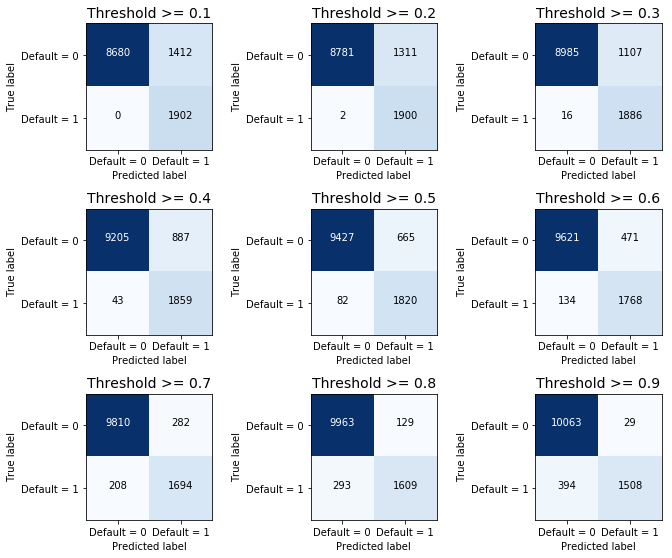

In [500]:
train_clf_threshold(df_train, LogisticRegression(), RandomUnderSampler())

Threshold: 0.1 | Test Recall: 1.0 | Test Roc Auc: 0.9
Threshold: 0.2 | Test Recall: 1.0 | Test Roc Auc: 0.93
Threshold: 0.3 | Test Recall: 0.99 | Test Roc Auc: 0.94
Threshold: 0.4 | Test Recall: 0.98 | Test Roc Auc: 0.94
Threshold: 0.5 | Test Recall: 0.96 | Test Roc Auc: 0.94
Threshold: 0.6 | Test Recall: 0.93 | Test Roc Auc: 0.94
Threshold: 0.7 | Test Recall: 0.88 | Test Roc Auc: 0.93
Threshold: 0.8 | Test Recall: 0.82 | Test Roc Auc: 0.91
Threshold: 0.9 | Test Recall: 0.64 | Test Roc Auc: 0.82


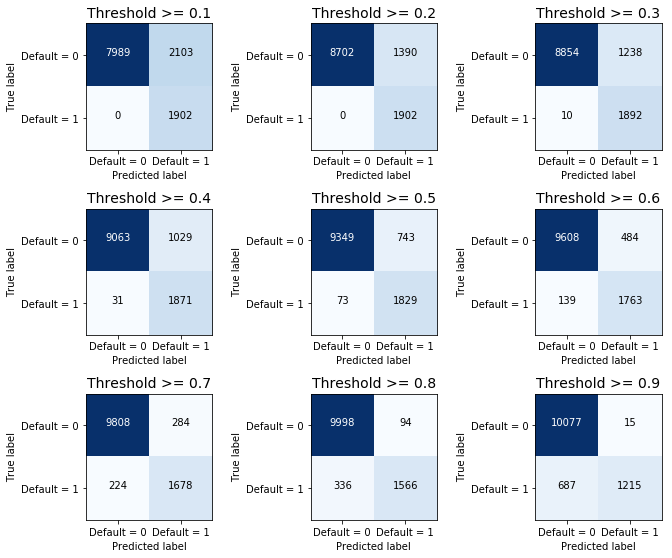

In [514]:
train_clf_threshold(df_train, RandomForestClassifier(), RandomUnderSampler())

By looking at the roc auc, the `Logistic Regression + Random Under Sampler` is the best model, so I will use this pipeline to make the predictions on the test set.

## Submission

In [536]:
pipeline, explainer, fnames = explainer(df_train, LogisticRegression(), RandomUnderSampler())

Valid	roc_auc:	0.907
Valid	recall:		0.822
Valid	accuracy:	0.965


In [544]:
x_test = df_test.drop('ids', axis=1)

In [546]:
y_pred = pipeline.predict(x_test)

In [547]:
predictions = pd.DataFrame()
predictions['ids'] = df_test['ids']
predictions['predictions'] = y_pred

In [550]:
predictions.to_csv('predictions.csv', index=False)

## Business

### Use of the model

The dataset contains some features that do not vary much along the time like demographic variables (sign, state, zip, gender), and some that may update along the time like scores, credit limit, etc.

In order to assess the risk of providing a loan for a customer, the model could be run once the customer data is in the database and periodically when any feature is updated.

We could also monitor the performance of the model by comparing the real default of customers that took out a loan with the predicted default by the model.

To improve the predictions, we could also build other models that could identify default from another point of view:

* **Financial Network:** Model based on the financial behaviour of the customer. Is she receiving more income than having expenses? Does the customer spend their earnings with superfluous goods or with important ones like rent or house bills? 


* **External Data:** Model based on variables provided by suppliers of data, like: Serasa, BVS, Big Data Corp. This model provide information of the customer with data that the credit company wouldn't have access otherwise.

### Best model according to business

So far, we have analyzed a model that gives us the best roc_auc, recall or accuracy.

However, from the business point of view, our main goal is to maximize gain by reducing costs of giving a loan to a customer that will never pay his debt, and increasing revenue from customers that will pay for loans that they took out.

To analyze the costs of each decision, we could build a cost matrix with the following concepts:

* **TN - True Negative:** customers the model predicted that will have `default = 0` and would pay the debt. We can assume gain of 500\$ for them.

* **FP - False Positive:** customers the model predicted that will have `default = 1` and would pay the debt. They don't represent any value, since we didn't provide any loan for them.

* **FN - False Negative:** customers the model predicted that will have `default = 0` and they wouldn't pay the debt. We can assume loss of 1000\$.

* **TP - True Positive:** customers the model predicted that will have `default = 1` and they wouldn't pay the debt. They don't represent any value, since we didn't provide any loan for them.

Now, we can build our cost_matrix as follows:

In [516]:
tn = 500
fp = 0
fn = -1000
tp = 0

cost_matrix = np.array([[tn, fp],
                        [fn, tp]])

print(cost_matrix)

[[  500     0]
 [-1000     0]]


In [504]:
def average_cost(y_test, y_pred, cost):
    c = confusion_matrix(y_test,y_pred)
    score = np.sum(c*cost)/np.sum(c)
    return score

Let's suppose that we have a dummy model that always predicts `default = 0`, so we provide loans to everyone.
Acording to the matrix, the average gain per customer is `262$`

Average gain: 262.1151986125471


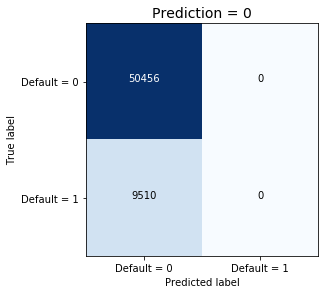

In [517]:
y_pred_0 = np.zeros(len(df_train), dtype='int')
y_pred_1 = np.ones(len(df_train), dtype='int')
y_default = df_train['default']

plot_confusion_matrix(y_default, y_pred_0, title='Prediction = 0')
print(f'Average gain: {average_cost(y_default, y_pred_0, cost_matrix)}')

And we had another dummy model that always predicts `default = 1`, so we never provide loans.
Acording to the matrix, the average gain per customer is `0$`

Average gain: 0.0


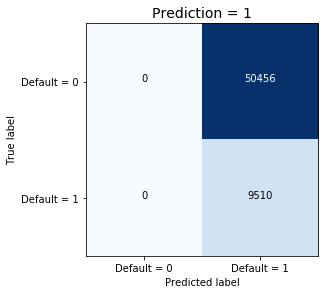

In [518]:
plot_confusion_matrix(y_default, y_pred_1, title='Prediction = 1')
print(f'Average gain: {average_cost(y_default, y_pred_1, cost_matrix)}')

Now, we can assess the pipelines and choose the one that can beat our baseline of `262$` and that has the highest average gain per customer.

In [551]:
def train_clf_threshold_cost(df, clf, cost, sampler=None):
    thresholds = np.arange(0.1, 1, 0.1)
    
    x_train, x_val, y_train, y_val = df_split(df)
    
    if sampler:
        pipeline = Pipeline([('minmax', MinMaxScaler()),
                             ('scaler', sampler),
                             ('clf', clf)])    
    else:
        pipeline = Pipeline([('minmax', MinMaxScaler()), ('clf', clf)])
            
    pipeline.fit(x_train, y_train)
    y_proba = pipeline.predict_proba(x_val)    

    for i in thresholds:
        y_pred = y_proba[:,1] > i
        avg_cost = average_cost(y_val, y_pred, cost)
        print(f"Threshold: {round(i, 1)} | Test Recall: {round(recall_score(y_val, y_pred), 2)} | Test Roc Auc: {round(roc_auc_score(y_val, y_pred), 2)} | Avg gain: {round(avg_cost, 2)}")

In [552]:
train_clf_threshold_cost(df_train, LogisticRegression(), cost_matrix, RandomUnderSampler())

Threshold: 0.1 | Test Recall: 1.0 | Test Roc Auc: 0.93 | Avg gain: 361.81
Threshold: 0.2 | Test Recall: 1.0 | Test Roc Auc: 0.93 | Avg gain: 364.68
Threshold: 0.3 | Test Recall: 0.99 | Test Roc Auc: 0.94 | Avg gain: 371.94
Threshold: 0.4 | Test Recall: 0.98 | Test Roc Auc: 0.94 | Avg gain: 379.36
Threshold: 0.5 | Test Recall: 0.96 | Test Roc Auc: 0.94 | Avg gain: 384.86
Threshold: 0.6 | Test Recall: 0.93 | Test Roc Auc: 0.94 | Avg gain: 388.9
Threshold: 0.7 | Test Recall: 0.9 | Test Roc Auc: 0.93 | Avg gain: 392.2
Threshold: 0.8 | Test Recall: 0.85 | Test Roc Auc: 0.92 | Avg gain: 390.78
Threshold: 0.9 | Test Recall: 0.79 | Test Roc Auc: 0.89 | Avg gain: 386.23


In [553]:
train_clf_threshold_cost(df_train, RandomForestClassifier(), cost_matrix, RandomUnderSampler())

Threshold: 0.1 | Test Recall: 1.0 | Test Roc Auc: 0.91 | Avg gain: 347.59
Threshold: 0.2 | Test Recall: 1.0 | Test Roc Auc: 0.93 | Avg gain: 363.52
Threshold: 0.3 | Test Recall: 1.0 | Test Roc Auc: 0.94 | Avg gain: 368.64
Threshold: 0.4 | Test Recall: 0.99 | Test Roc Auc: 0.94 | Avg gain: 375.23
Threshold: 0.5 | Test Recall: 0.97 | Test Roc Auc: 0.95 | Avg gain: 382.32
Threshold: 0.6 | Test Recall: 0.93 | Test Roc Auc: 0.94 | Avg gain: 387.36
Threshold: 0.7 | Test Recall: 0.89 | Test Roc Auc: 0.93 | Avg gain: 390.7
Threshold: 0.8 | Test Recall: 0.83 | Test Roc Auc: 0.91 | Avg gain: 388.4
Threshold: 0.9 | Test Recall: 0.67 | Test Roc Auc: 0.83 | Avg gain: 367.27


We can see that, even though the pipeline that has the highest roc auc is `Logistic Regression + Random Under Sampler` with `threshold = 0.5`, the pipeline that gives us the highest gain is `Logistic Regression + Random Under Sampler` with `threshold = 0.7`.

Comparing with our baseline of `262$`, the best pipeline gives us an increase of `130$ (392$ - 262$)` of profit per customer. 